In [2]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt


from PIL import Image
from tqdm import tqdm

In [147]:
15450 / 30

515.0

In [3]:
IMAGE_ROOT_DIR = "/kaggle/input/faces-dcgan/dataset"

image_np = []
image_class = []

for data in tqdm(os.listdir(IMAGE_ROOT_DIR)):
    class_dir = f"{IMAGE_ROOT_DIR}/{data}/"
    class_content = os.listdir(class_dir)
    for image in class_content:
        image_path = f"{class_dir}/{image}"
        image_f = Image.open(image_path)
        image_f = image_f.resize((64, 64))
        image_f = np.array(image_f) / 255.0
        image_class.append(data)
        image_np.append(image_f)
        
image_np = np.array(image_np)
print(image_np.shape)

100%|██████████| 6/6 [04:05<00:00, 40.87s/it]


(15453, 64, 64, 3)


In [117]:
image_np = np.reshape(image_np, (-1,3,64,64))
image_np = image_np[:-3]

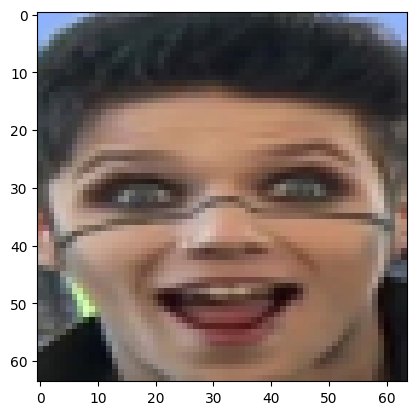

In [150]:
plt.imshow(image_np[0].reshape(64,64,3))
plt.show()

In [151]:
from torch.utils.data import Dataset, DataLoader

In [152]:
class FacesDataset(Dataset):
    def __init__(self, images):
        self.images = images
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.images[idx]).float()

In [153]:
BATCH_SIZE = 30

In [154]:
imageDataset = FacesDataset(image_np)
imageDataloader = DataLoader(imageDataset, batch_size=BATCH_SIZE, shuffle=True)

## Model

In [155]:
import torch
import torch.nn as nn
import torch.optim as optim

In [156]:
device = "cuda" if torch.cuda.is_available() else "cpu"
LATENT_DIM = 100

In [157]:
t = torch.randn((1,100,1,1))
x = nn.ConvTranspose2d(100,128, 4, 2,1, bias=False)

In [164]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [165]:
class FaceGenerator(nn.Module):
    def __init__(self, in_channels):
        super(FaceGenerator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels, 1024, 4, 2,0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True), # [batch_size, 1024, 2, 2]

            nn.ConvTranspose2d(1024, 512, 4, 2,1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True), # [batch_size, 512, 7, 7]

            nn.ConvTranspose2d(512, 256, 4, 2,1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True), # [batch_size, 256, 14, 14]

            nn.ConvTranspose2d(256, 128, 4, 2,1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True), # [batch_size, 256, 28, 28]
            
            nn.ConvTranspose2d(128,3, 4, 2,1, bias=False),
            nn.Sigmoid(), # [batch_size, 1, 32, 32]
        )

    def forward(self, x):
        return self.main(x)

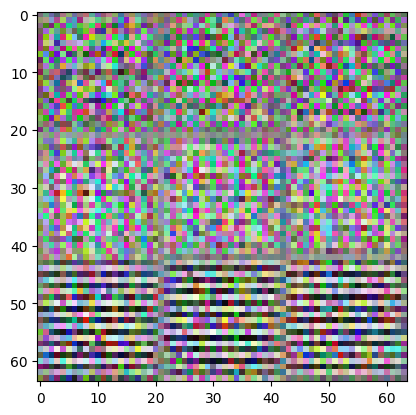

In [166]:
faceGenerator = FaceGenerator(in_channels=100).to(device)
with torch.no_grad():
    t = torch.randn((30,100,1,1)).to(device)
    p = faceGenerator(t).detach().cpu().numpy()[0].reshape(64, 64,3)
    plt.imshow(p)

In [167]:
class FaceDiscriminator(nn.Module):
    def __init__(self, in_channels = 3):
        super(FaceDiscriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2,0, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,True), # [batch_size, 1024, 2, 2]

            nn.Conv2d(64, 128, 4, 2,1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,True), # [batch_size, 512, 7, 7]

            nn.Conv2d(128, 256, 4, 2,1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,True), # [batch_size, 256, 14, 14]

            nn.Conv2d(256, 512, 4, 2,1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,True), # [batch_size, 256, 28, 28]
            
            nn.Conv2d(512,1, 4, 2,1, bias=False),
            nn.Flatten(),
            nn.Sigmoid(), # [batch_size, 1, 32, 32]
        )

    def forward(self, x):
        return self.main(x)

In [168]:
faceDiscriminator = FaceDiscriminator().to(device)
with torch.no_grad():
    t = torch.randn((30,3,64,64)).to(device)
    td = faceDiscriminator(t)
    print(td.shape)

torch.Size([30, 1])


**Training**

In [169]:
criterion = nn.BCELoss()

optimizerG = optim.Adam(faceGenerator.parameters(), lr=0.0002)
optimizerD = optim.Adam(faceDiscriminator.parameters(), lr=0.0002)

fixedLatent = torch.randn((16,100,1,1)).to(device)

num_epochs = 400

loss_d_history = []
loss_g_history = []

[0/400][0/515] Loss_D = 0.707911491394043 Loss_G = 2.062220811843872 loss_D_fake = 0.7389904260635376
[0/400][50/515] Loss_D = 0.23705646395683289 Loss_G = 6.516726016998291 loss_D_fake = 0.04841326177120209
[0/400][100/515] Loss_D = 0.4316704571247101 Loss_G = 7.093396186828613 loss_D_fake = 0.03535144403576851
[0/400][150/515] Loss_D = 0.01818321831524372 Loss_G = 6.012410640716553 loss_D_fake = 0.03326615318655968
[0/400][200/515] Loss_D = 0.013405858539044857 Loss_G = 6.727818012237549 loss_D_fake = 0.08099810034036636
[0/400][250/515] Loss_D = 0.005545197054743767 Loss_G = 7.233346939086914 loss_D_fake = 0.024625347927212715
[0/400][300/515] Loss_D = 0.013235838152468204 Loss_G = 7.7593560218811035 loss_D_fake = 0.04881323501467705
[0/400][350/515] Loss_D = 0.007535743992775679 Loss_G = 6.9161810874938965 loss_D_fake = 0.035348039120435715
[0/400][400/515] Loss_D = 0.02134815603494644 Loss_G = 9.234347343444824 loss_D_fake = 0.006503800395876169
[0/400][450/515] Loss_D = 0.0156187

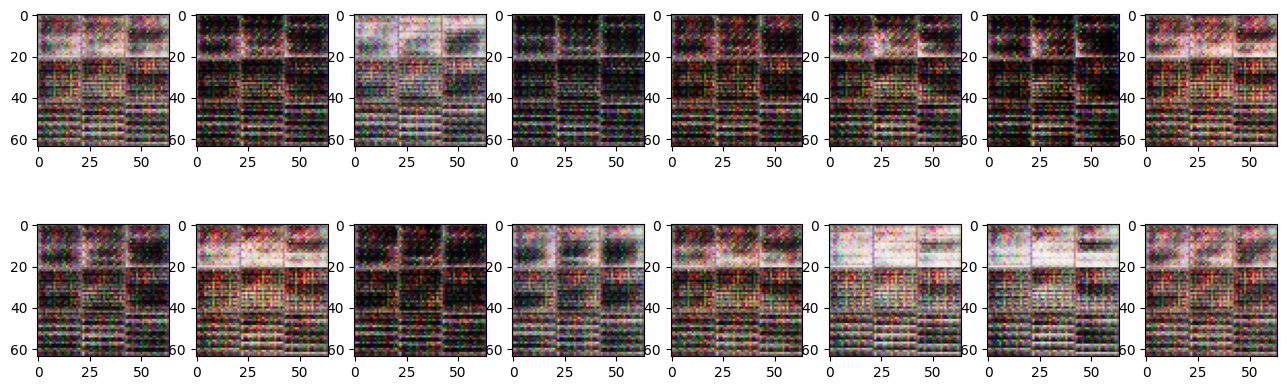

[1/400][0/515] Loss_D = 0.013741953298449516 Loss_G = 8.06103515625 loss_D_fake = 0.005983353592455387
[1/400][50/515] Loss_D = 0.01761135458946228 Loss_G = 7.365087032318115 loss_D_fake = 0.014340494759380817
[1/400][100/515] Loss_D = 0.32839351892471313 Loss_G = 10.719611167907715 loss_D_fake = 0.00023252275423146784
[1/400][150/515] Loss_D = 0.05334010347723961 Loss_G = 9.07056713104248 loss_D_fake = 0.005826166365295649
[1/400][200/515] Loss_D = 0.00013550826406572014 Loss_G = 6.536064147949219 loss_D_fake = 0.002853838726878166
[1/400][250/515] Loss_D = 2.2590358639718033e-05 Loss_G = 8.499201774597168 loss_D_fake = 0.03631987422704697
[1/400][300/515] Loss_D = 0.11108265817165375 Loss_G = 7.850643157958984 loss_D_fake = 0.023005835711956024
[1/400][350/515] Loss_D = 0.03839251771569252 Loss_G = 9.94308090209961 loss_D_fake = 0.010526439175009727
[1/400][400/515] Loss_D = 0.07893488556146622 Loss_G = 5.666811466217041 loss_D_fake = 0.11520260572433472
[1/400][450/515] Loss_D = 0.1

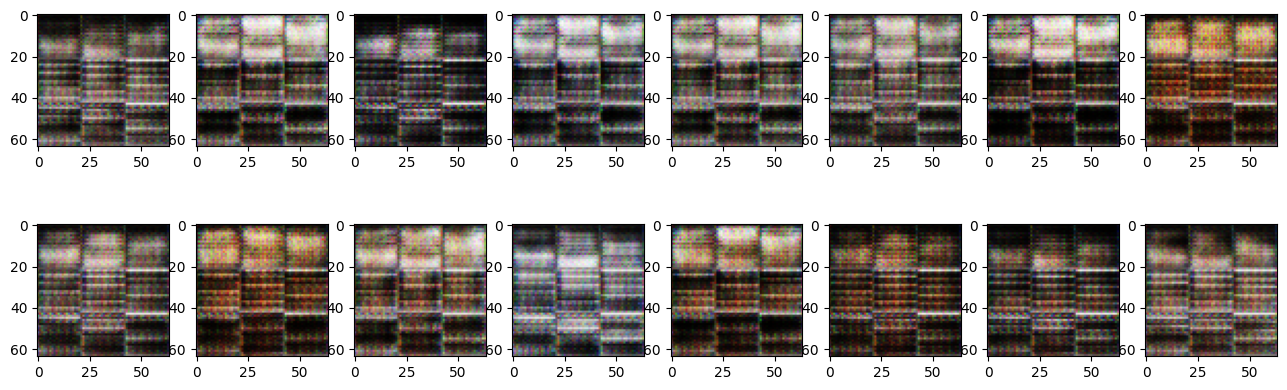

[2/400][0/515] Loss_D = 0.006363666616380215 Loss_G = 7.932985782623291 loss_D_fake = 0.03415177762508392
[2/400][50/515] Loss_D = 0.025324387475848198 Loss_G = 8.68834114074707 loss_D_fake = 0.1171984076499939
[2/400][100/515] Loss_D = 0.0368986539542675 Loss_G = 12.396392822265625 loss_D_fake = 0.0006172439898364246
[2/400][150/515] Loss_D = 0.018629519268870354 Loss_G = 10.24409008026123 loss_D_fake = 0.0026888526044785976
[2/400][200/515] Loss_D = 0.07468290627002716 Loss_G = 5.938227653503418 loss_D_fake = 0.042772091925144196
[2/400][250/515] Loss_D = 0.02623048610985279 Loss_G = 9.230365753173828 loss_D_fake = 0.005335810128599405
[2/400][300/515] Loss_D = 0.08405979722738266 Loss_G = 7.628249645233154 loss_D_fake = 0.20516084134578705
[2/400][350/515] Loss_D = 0.005163505673408508 Loss_G = 5.42366886138916 loss_D_fake = 0.037373971194028854
[2/400][400/515] Loss_D = 0.042603474110364914 Loss_G = 12.853362083435059 loss_D_fake = 4.2962070438079536e-05
[2/400][450/515] Loss_D = 0

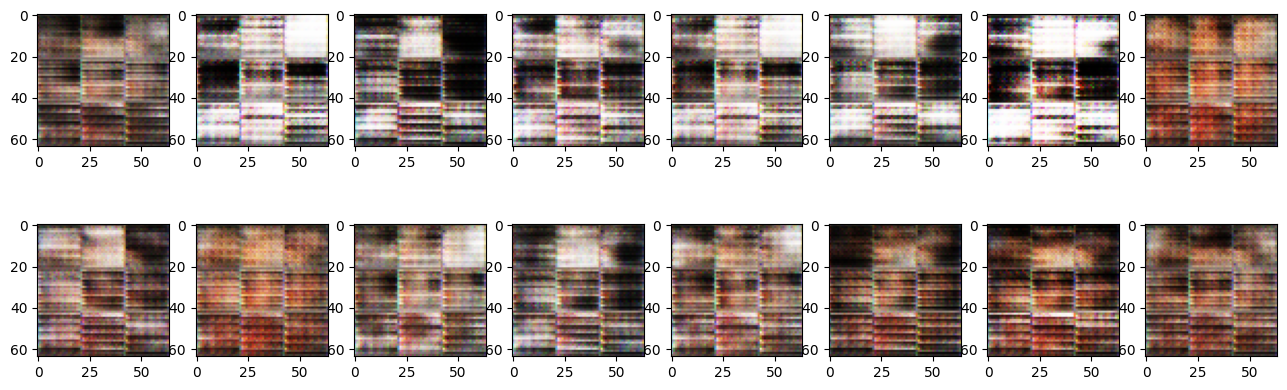

[3/400][0/515] Loss_D = 0.01805260218679905 Loss_G = 7.230097770690918 loss_D_fake = 0.06987394392490387
[3/400][50/515] Loss_D = 0.05471131205558777 Loss_G = 6.004100799560547 loss_D_fake = 0.032931990921497345
[3/400][100/515] Loss_D = 0.06621299684047699 Loss_G = 6.0739054679870605 loss_D_fake = 0.030300140380859375
[3/400][150/515] Loss_D = 0.02117534913122654 Loss_G = 5.564749240875244 loss_D_fake = 0.05929402634501457
[3/400][200/515] Loss_D = 0.024554947391152382 Loss_G = 6.943191051483154 loss_D_fake = 0.02499396912753582
[3/400][250/515] Loss_D = 0.04137708619236946 Loss_G = 6.323841094970703 loss_D_fake = 0.03825338929891586
[3/400][300/515] Loss_D = 0.04757558926939964 Loss_G = 6.322305679321289 loss_D_fake = 0.09814649075269699
[3/400][350/515] Loss_D = 0.0028214247431606054 Loss_G = 7.358096599578857 loss_D_fake = 0.01606026105582714
[3/400][400/515] Loss_D = 0.1820797324180603 Loss_G = 8.727161407470703 loss_D_fake = 0.0018123326590284705
[3/400][450/515] Loss_D = 0.02239

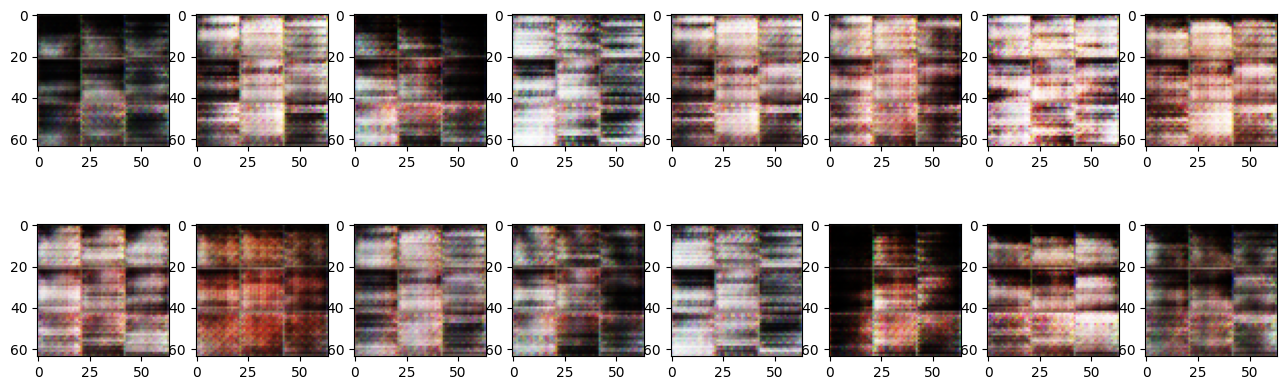

[4/400][0/515] Loss_D = 0.1175009235739708 Loss_G = 7.734957218170166 loss_D_fake = 0.013199732638895512
[4/400][50/515] Loss_D = 0.03353762626647949 Loss_G = 6.519489765167236 loss_D_fake = 0.061515603214502335
[4/400][100/515] Loss_D = 0.04552486166357994 Loss_G = 6.316099166870117 loss_D_fake = 0.01433804351836443
[4/400][150/515] Loss_D = 0.051477521657943726 Loss_G = 6.823545455932617 loss_D_fake = 0.07550283521413803
[4/400][200/515] Loss_D = 0.057558365166187286 Loss_G = 4.931161403656006 loss_D_fake = 0.017801273614168167
[4/400][250/515] Loss_D = 0.07239366322755814 Loss_G = 7.109404563903809 loss_D_fake = 0.005082066170871258
[4/400][300/515] Loss_D = 0.01056066993623972 Loss_G = 5.527871131896973 loss_D_fake = 0.08046911656856537
[4/400][350/515] Loss_D = 0.21832458674907684 Loss_G = 6.466411590576172 loss_D_fake = 0.19368954002857208
[4/400][400/515] Loss_D = 0.2810623347759247 Loss_G = 5.507269382476807 loss_D_fake = 0.029166903346776962
[4/400][450/515] Loss_D = 0.0785063

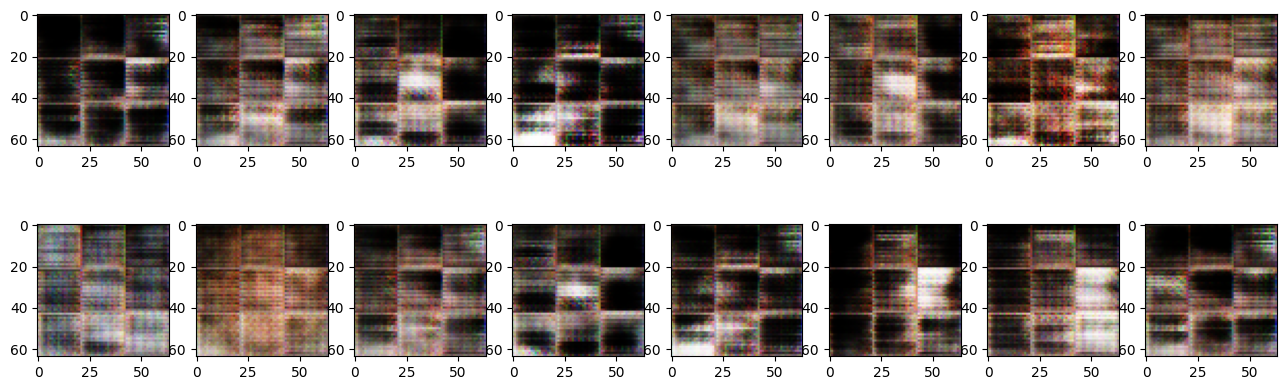

[5/400][0/515] Loss_D = 0.004133224952965975 Loss_G = 4.804959774017334 loss_D_fake = 0.04025096446275711
[5/400][50/515] Loss_D = 0.06712118536233902 Loss_G = 5.985797882080078 loss_D_fake = 0.038468990474939346
[5/400][100/515] Loss_D = 0.07164356112480164 Loss_G = 6.380385875701904 loss_D_fake = 0.03126203268766403
[5/400][150/515] Loss_D = 0.01983715035021305 Loss_G = 4.775959491729736 loss_D_fake = 0.1855531632900238
[5/400][200/515] Loss_D = 0.1637430191040039 Loss_G = 5.009000778198242 loss_D_fake = 0.026848023757338524
[5/400][250/515] Loss_D = 0.059822648763656616 Loss_G = 6.663731098175049 loss_D_fake = 0.03356146067380905
[5/400][300/515] Loss_D = 0.03609243780374527 Loss_G = 5.730104446411133 loss_D_fake = 0.09328973293304443
[5/400][350/515] Loss_D = 0.008017991669476032 Loss_G = 4.634002208709717 loss_D_fake = 0.5897618532180786
[5/400][400/515] Loss_D = 0.10428913682699203 Loss_G = 6.514067649841309 loss_D_fake = 0.03922899067401886
[5/400][450/515] Loss_D = 0.0889846235

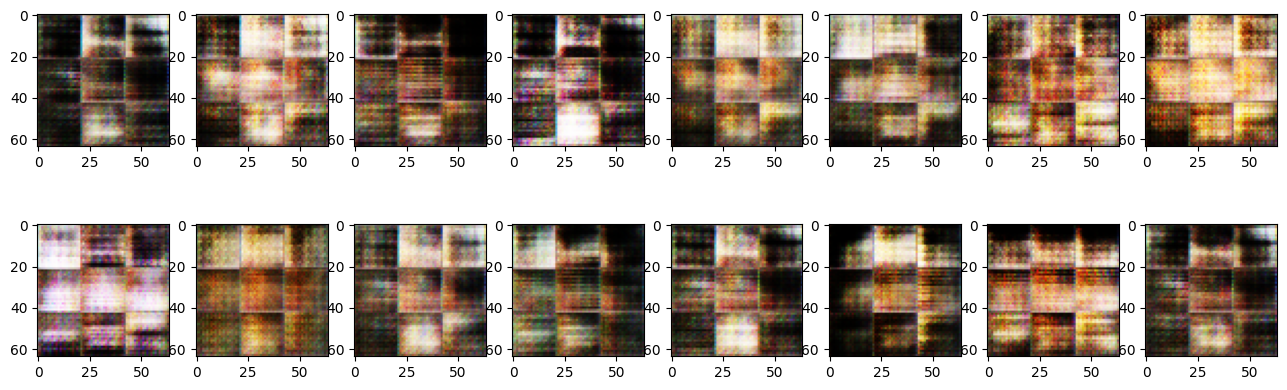

[6/400][0/515] Loss_D = 0.006281223148107529 Loss_G = 6.362564563751221 loss_D_fake = 0.24195720255374908
[6/400][50/515] Loss_D = 0.02227555401623249 Loss_G = 6.877694606781006 loss_D_fake = 0.03504433482885361


In [ ]:
for epoch in range(num_epochs):
    for idx, data in enumerate(imageDataloader):
        
        optimizerD.zero_grad()
        
        feat = data.to(device)
        
        # discriminator loss - real images
        real_labels = torch.ones((BATCH_SIZE, 1)).to(device)
        output = faceDiscriminator(feat)
        loss_d = criterion(output, real_labels)
        
        loss_d.backward()
        
        # discriminator loss - fake images
        
        fake_noise = torch.randn((BATCH_SIZE,100,1,1)).to(device)
        fake_labels = torch.zeros((BATCH_SIZE, 1)).to(device)
        
        output_g = faceGenerator(fake_noise)
        output_d = faceDiscriminator(output_g.detach())
        loss_d_fake = criterion(output_d, fake_labels)
        
        loss_d_fake.backward()
        
        # discriminator step
        
        optimizerD.step()
        
        # generator 
        
        optimizerG.zero_grad()
        
        real_g_labels = torch.ones((BATCH_SIZE, 1)).to(device)
        gen_disc_op = faceDiscriminator(output_g)
        loss_g = criterion(gen_disc_op, real_g_labels)
        
        loss_g.backward()
        optimizerG.step()
        
        # loggin
        
        if idx%50 == 0:
            print(f"[{epoch}/{num_epochs}][{idx}/{len(imageDataloader)}] Loss_D = {loss_d.item()} Loss_G = {loss_g.item()} loss_D_fake = {loss_d_fake}")
 
    # print one row of outputs
    with torch.no_grad():
        gen_op = faceGenerator(fixedLatent).detach().cpu().numpy()
        fig = plt.figure(figsize=(16,5))
        for i in range(len(gen_op)):
            plt.subplot(2,8, i+1)
            img = gen_op[i].reshape(64,64,3)
            plt.imshow(img)
        
        plt.show()
            